In [1]:
import tensorflow as tf
import tensorflow.keras.datasets.mnist as mnist
from PIL import Image, ImageDraw

import matplotlib.pyplot as plt
import numpy as np
import random

2023-09-10 00:28:23.833075: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-10 00:28:23.865857: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-10 00:28:24.460894: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()

# Making sure that the values are float so that we can get decimal points after division
mnist_x_train = mnist_x_train.astype('float32')
mnist_x_test = mnist_x_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
mnist_x_train /= 255
mnist_x_test /= 255

5


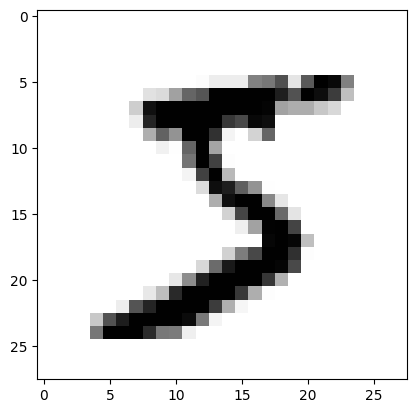

In [3]:
plt.imshow(mnist_x_train[0], cmap="gray_r")
print(mnist_y_train[0])

In [4]:
def reposition_image_on_canvas(image, label, final_dim):
    if (random.random() < 0.2):
        return np.zeros(shape=final_dim), (
            0,      # number does not exist
            0,      # a custom loss function will deal with the rest of this
            (0, 0, 1, 1)
        )

    image = np.asarray(image)

    # calculates where the digit begins and ends, cropping the white space
    nonwhite_positions = np.nonzero(image)
    h_start, v_start, h_end, v_end = (np.min(nonwhite_positions[0]), np.min(nonwhite_positions[1]), max(nonwhite_positions[0]), max(nonwhite_positions[1]))
    image = image[h_start:h_end, v_start:v_end]

    image = Image.fromarray(image)
    image = image.rotate(random.random() * 90 - 45, Image.NEAREST, expand = 1)

    new_height = max(int(image.size[0] * 0.5), 1)
    new_width = max(int(image.size[1] * 0.5), 1)

    image = image.resize((new_width, new_height))
    image = np.asarray(image)

    # adds random padding to the image, returning an i
    available_space = np.subtract(final_dim, image.shape)
    begin = (random.randint(0, available_space[0]), random.randint(0, available_space[1]))
    end = available_space - begin

    padded_image = np.pad(image, ((begin[0], end[0]), (begin[1], end[1])), mode="constant", constant_values=0)

    return padded_image, (
        1,                          # number exists
        label,
        (
            begin[1] / final_dim[1],          # bounding box x-position (relative to total width)
            begin[0] / final_dim[0],          # bounding box y-position (relative to total height)
            image.shape[1] / final_dim[1],    # bounding box width (relative to total width)
            image.shape[0] / final_dim[0]     # bounding box height (relative to total height)
        )
    )

def draw_bounding_box(image, true_label, pred_label=None):
    bounded_image = Image.fromarray(255 - image * 255).convert("RGB")
    draw = ImageDraw.Draw(bounded_image)

    true_exists, (true_x, true_y, true_w, true_h) = true_label
    true_x, true_y, true_w, true_h = true_x * image.shape[1], true_y * image.shape[1], true_w * image.shape[1], true_h * image.shape[1]

    if (true_exists):
        draw.rectangle((true_x, true_y, true_x + true_w, true_y + true_h), outline="green", width=1)

    if (pred_label):
        pred_exists, (pred_x, pred_y, pred_w, pred_h) = pred_label
        pred_x, pred_y, pred_w, pred_h = pred_x * image.shape[1], pred_y * image.shape[1], pred_w * image.shape[1], pred_h * image.shape[1]

        if (np.round(pred_exists)):
            draw.rectangle((pred_x, pred_y, pred_x + pred_w, pred_y + pred_h), outline="red", width=1)

    return bounded_image

In [5]:
x_train, exists_train, y_train, dim_train = [], [], [], []
x_test, exists_test, y_test, dim_test = [], [], [], []

IMAGE_SIZE = 64

for i in range(mnist_x_train.shape[0]):
    x, (e, c, d) = reposition_image_on_canvas(mnist_x_train[i], mnist_y_train[i], (IMAGE_SIZE, IMAGE_SIZE))
    x_train.append(x)
    exists_train.append(e)
    y_train.append(c)
    dim_train.append(d)

for i in range(mnist_x_test.shape[0]):
    x, (e, c, d) = reposition_image_on_canvas(mnist_x_test[i], mnist_y_test[i], (IMAGE_SIZE, IMAGE_SIZE))
    x_test.append(x)
    exists_test.append(e)
    y_test.append(c)
    dim_test.append(d)

2


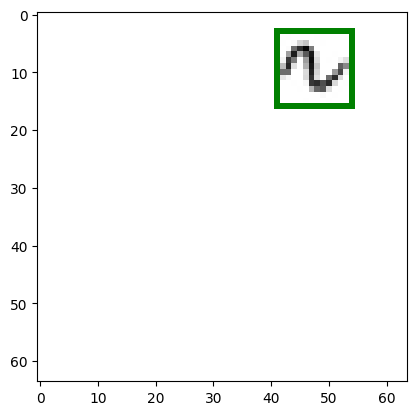

In [6]:
index = 76
plt.imshow(draw_bounding_box(x_train[index], (exists_train[index], dim_train[index])))
print(y_train[index])

In [7]:
x_train = np.asarray(x_train)
exists_train = np.asarray(exists_train)
y_train = np.asarray(y_train)
dim_train = np.asarray(dim_train)

x_test = np.asarray(x_test)
exists_test = np.asarray(exists_test)
y_test = np.asarray(y_test)
dim_test = np.asarray(dim_test)

x_train = x_train.reshape(x_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
x_test = x_test.reshape(x_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 1)

print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

x_train shape: (60000, 64, 64, 1)
Number of images in x_train 60000
Number of images in x_test 10000


In [8]:
# Importing the required Keras modules containing model and layers
from keras.models import Model
from keras.layers import Layer, Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, Input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.metrics import IoU
from tensorflow.keras.utils import plot_model


def initialize_base_network():
	input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name="base_input")
	
	x = input

	for i in range(0, 4):
		filters = 2 ** (4 + i)

		x = Conv2D(filters, 3, activation="relu", padding="SAME")(x)
		x = Conv2D(filters, 3, activation="relu", padding="SAME")(x)
		x = MaxPooling2D((2, 2))(x)
		
	x = Flatten()(x)
	x = Dense(256, activation="relu")(x)

	exists_out = Dense(1, activation="sigmoid", name="existence_output")(x)
	label_out = Dense(10, activation="softmax", name="label_output")(x)
	dim_out = Dense(4, activation="sigmoid", name="dimensions_output")(x)

	return Model(inputs=input, outputs=[exists_out, label_out, dim_out])
		

2023-09-10 00:28:35.728238: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-10 00:28:35.753118: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-10 00:28:35.753517: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-10 00:28:35.756500: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-10 00:28:35.756845: I tensorflow/compile

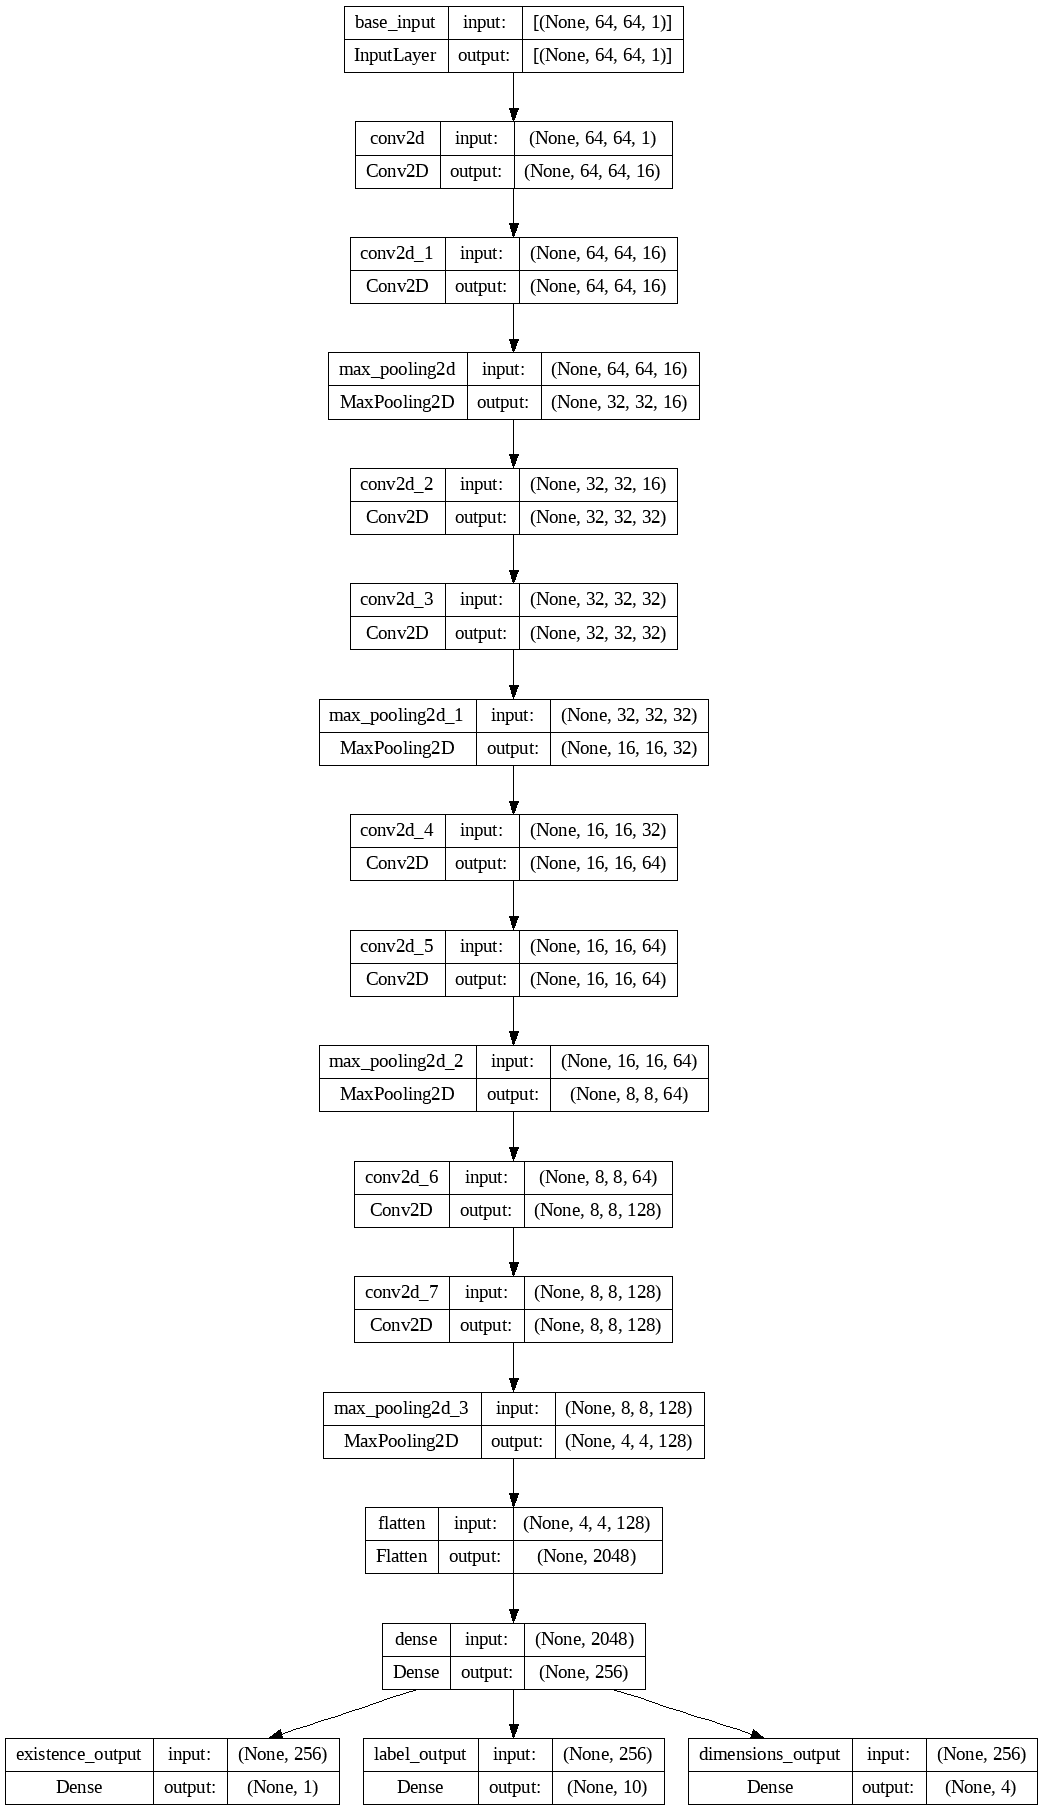

In [9]:
model = initialize_base_network()

plot_model(model, show_shapes=True, show_layer_names=True)

In [10]:
class IoU(tf.keras.metrics.Metric):
    def __init__(self, **kwargs):
        super(IoU, self).__init__(**kwargs)

        self.iou = self.add_weight(name="iou", initializer="zeros")
        self.total_iou = self.add_weight(name="iou", initializer="zeros")
        self.num_ex = self.add_weight(name="num_ex", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        def get_box(y):
            x1, x2 = y[:, 0], y[:, 2]
            x2 = tf.math.add(x1, x2)
            y1, y2 = y[:, 1], y[:, 3]
            y2 = tf.math.add(y1, y2)
            return x1, y1, x2, y2

        def get_area(x1, y1, x2, y2):
            return tf.math.abs(x2 - x1) * tf.math.abs(y2 - y1)
        
        gt_x1, gt_y1, gt_x2, gt_y2 = get_box(y_true)
        p_x1, p_y1, p_x2, p_y2 = get_box(y_pred)

        i_x1 = tf.maximum(gt_x1, p_x1)
        i_y1 = tf.maximum(gt_y1, p_y1)
        i_x2 = tf.minimum(gt_x2, p_x2)
        i_y2 = tf.minimum(gt_y2, p_y2)

        i_area = get_area(i_x1, i_y1, i_x2, i_y2)
        u_area = get_area(gt_x1, gt_y1, gt_x2, gt_y2) + get_area(p_x1, p_y1, p_x2, p_y2) - i_area

        iou = tf.math.divide_no_nan(i_area, u_area)

        self.num_ex.assign_add(1)
        self.total_iou.assign_add(tf.reduce_mean(iou))
        self.iou = tf.math.divide(self.total_iou, self.num_ex)

    def result(self):
        return self.iou
    
    def reset_state(self):
        self.iou = self.add_weight(name="iou", initializer="zeros")
        self.total_iou = self.add_weight(name="iou", initializer="zeros")
        self.num_ex = self.add_weight(name="num_ex", initializer="zeros")
        


In [16]:
model.compile(loss={
        "existence_output": "binary_crossentropy",
        "label_output": "sparse_categorical_crossentropy",
        "dimensions_output": "mse"
    },
    optimizer="adam",
    metrics={
        "existence_output": "binary_accuracy",
        "label_output": "sparse_categorical_accuracy",
        "dimensions_output": IoU(name="iou")
    },
)

history = model.fit(x_train, [exists_train, y_train, dim_train], epochs=30, batch_size=64,
                    validation_data=(x_test, [exists_test, y_test, dim_test]),
                    callbacks=[ModelCheckpoint("./model", monitor="val_dimensions_output_iou", save_best_only=True)]
)

In [12]:
# model = tf.keras.saving.load_model("./model")

In [13]:
model.evaluate(x_test, [exists_test, y_test, dim_test])

313/313 [==============================] - 6s 17ms/step - loss: 0.1333 - existence_output_loss: 2.3751e-04 - label_output_loss: 0.1318 - dimensions_output_loss: 0.0013 - existence_output_binary_accuracy: 1.0000 - label_output_sparse_categorical_accuracy: 0.9593 - dimensions_output_iou: 0.0000e+00


[0.13329270482063293,
 0.00023751473054289818,
 0.13180406391620636,
 0.0012510261731222272,
 1.0,
 0.9592999815940857,
 0.0]

In [14]:
exists_pred, y_pred, dim_pred = model.predict(x_test)

313/313 [==============================] - 2s 6ms/step


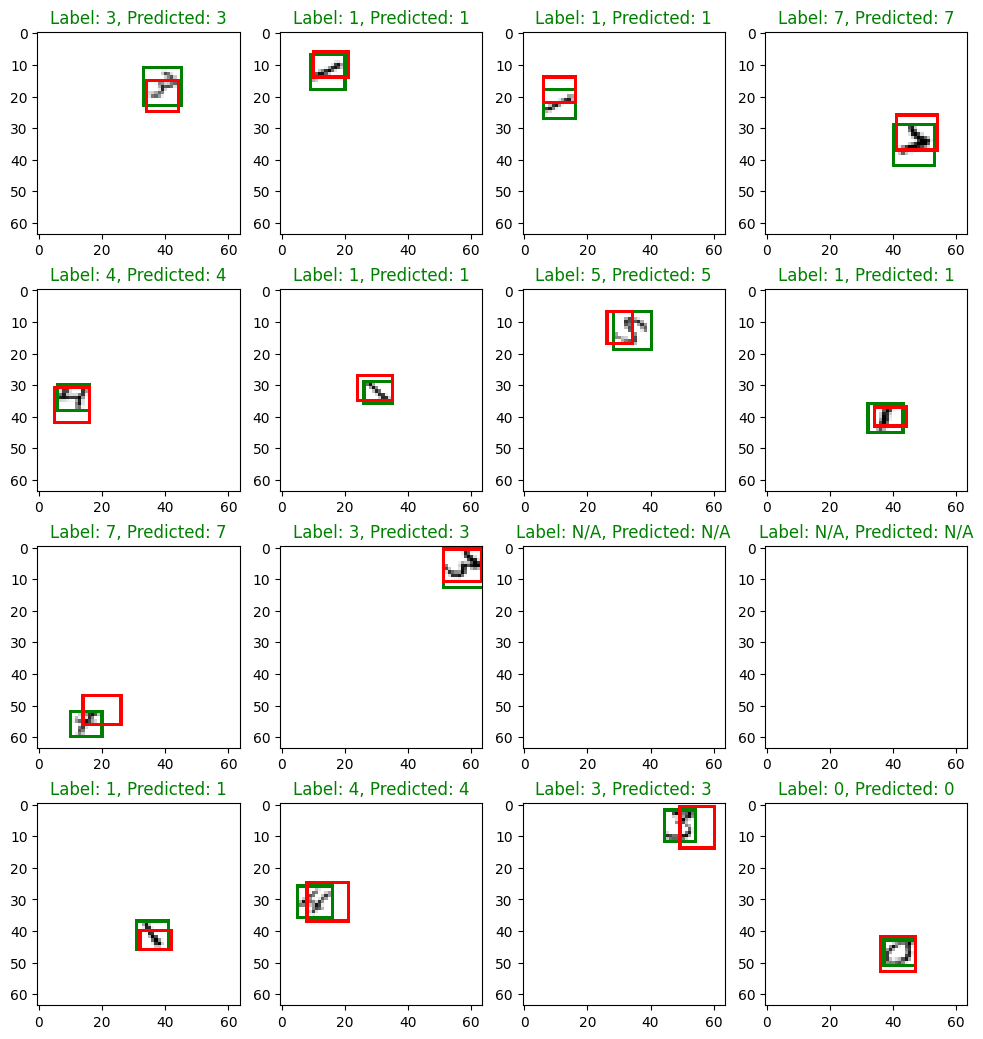

In [15]:
fig = plt.figure(figsize=([12, 12.8]))

rows = 4
columns = 4

for i in range(rows * columns):
    fig.add_subplot(rows, columns, i + 1)
    
    index = random.randint(0, x_test.shape[0])
    image = x_test[index].reshape(IMAGE_SIZE, IMAGE_SIZE)

    image = draw_bounding_box(image, (exists_test[index], dim_test[index]), (exists_pred[index], dim_pred[index]))

    # showing image
    plt.imshow(image)
    plt.title("Label: {}, Predicted: {}".format(
            y_test[index] if (exists_test[index]) else "N/A",
            np.argmax(y_pred[index]) if (np.round(exists_pred[index])) else "N/A",
        ),
        color="green" if (exists_test[index] == np.round(exists_pred[index]) and y_test[index] == np.argmax(y_pred[index])) else "red"
    )